In [39]:
#Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import contextlib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('/home/onyxia/work/Macroeconometrics')
from src.preprocessing import apply_transformation

In [26]:
#Main data
fred_md = pd.read_csv("/home/onyxia/work/Macroeconometrics/data/fred_md_2024_12.csv")
#Metadata
fred_info = pd.read_csv("/home/onyxia/work/Macroeconometrics/data/FRED_MD_updated_appendix.csv", encoding="latin1")
#Recession variable
us_rec = pd.read_csv("/home/onyxia/work/Macroeconometrics/data/USREC.csv")

In [27]:
#Indexing the dataset with dates
fred_md_short = (
    fred_md.iloc[1:]
    .assign(sasdate=pd.to_datetime(fred_md.iloc[1:].sasdate, format="%m/%d/%Y"))
    .set_index("sasdate")
)

#Transformation of series based on metadata
for _, row in fred_info.iterrows():
    series_name = row['fred']
    transformation_code = row['tcode']

    with contextlib.suppress(Exception):
        fred_md_short[series_name] = apply_transformation(fred_md_short[series_name], transformation_code)

#Filtering data by date
start_date = "1960"
end_date = "2024"
fred_md_short = fred_md_short[
    (fred_md_short.index >= start_date) & (fred_md_short.index <= end_date)
].dropna(axis=1)

#Addition of the variable of interest (American recession)
us_rec = us_rec.assign(
    observation_date=pd.to_datetime(us_rec.observation_date)
).set_index("observation_date")
us_rec = us_rec.loc[fred_md_short.index,:]

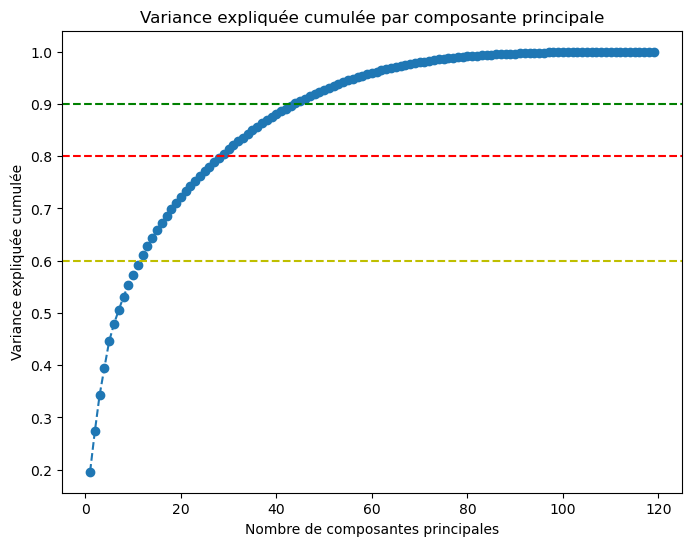

In [44]:
#Normalization of data
scaler = StandardScaler()
fred_md_scaled = scaler.fit_transform(fred_md_short)

#Apply PCA without specifying the number of components (to obtain all components)
pca = PCA()
pca.fit(fred_md_scaled)

#Calculate the variance explained by each component
explained_variance = pca.explained_variance_ratio_

#Plot cumulative explained variance
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title("Cumulative explained variance by principal component")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.axhline(y=0.60, color='y', linestyle='--')  #Ligne pour 60% de variance expliquée
plt.axhline(y=0.80, color='r', linestyle='--')  #Ligne pour 80% de variance expliquée
plt.axhline(y=0.90, color='g', linestyle='--')  #Ligne pour 90% de variance expliquée
plt.show()

In [49]:
# Find the number of components for 60%, 80%, and 90% explained variance
optimal_components_60 = (cumulative_variance >= 0.60).argmax() + 1
optimal_components_80 = (cumulative_variance >= 0.80).argmax() + 1
optimal_components_90 = (cumulative_variance >= 0.90).argmax() + 1

print(f"Nombre de composantes pour 60% de variance expliquée : {optimal_components_60}")
print(f"Nombre de composantes pour 80% de variance expliquée : {optimal_components_80}")
print(f"Nombre de composantes pour 90% de variance expliquée : {optimal_components_90}")

# Apply PCA with these numbers of components
pca_60 = PCA(n_components=optimal_components_60)
pca_80 = PCA(n_components=optimal_components_80)
pca_90 = PCA(n_components=optimal_components_90)

# Transform data with these PCAs
pca_60_components = pca_60.fit_transform(fred_md_scaled)
pca_80_components = pca_80.fit_transform(fred_md_scaled)
pca_90_components = pca_90.fit_transform(fred_md_scaled)

# Convert results to DataFrame
pca_60_df = pd.DataFrame(pca_60_components, columns=[f'PC{i+1}' for i in range(optimal_components_60)])
pca_80_df = pd.DataFrame(pca_80_components, columns=[f'PC{i+1}' for i in range(optimal_components_80)])
pca_90_df = pd.DataFrame(pca_90_components, columns=[f'PC{i+1}' for i in range(optimal_components_90)])

Nombre de composantes pour 60% de variance expliquée : 12
Nombre de composantes pour 80% de variance expliquée : 29
Nombre de composantes pour 90% de variance expliquée : 44
Dataset PCA pour 90% de variance expliquée:


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST
sasdate,,,,,,,,,,,,,,,,,,,,,
1960-01-01,0.003226,0.004661,0.002791,0.016963,0.026606,0.025919,0.024097,0.029021,0.031234,0.103833,...,-0.001751,-0.002588,-0.001845,-0.001246,-0.004680,0.007797,-0.009705,0.004292,-0.011739,-0.013330
1960-02-01,0.001147,0.000906,0.004361,0.014403,0.003696,-0.008937,-0.005686,-0.003436,-0.011454,-0.013856,...,0.001620,0.003750,0.001683,0.000858,-0.004555,0.003853,-0.004750,0.008268,0.005388,-0.018942
1960-03-01,0.001877,0.000905,0.014089,-0.028040,-0.001102,-0.009021,-0.003427,-0.001151,0.001151,-0.019967,...,-0.000454,-0.004537,0.001791,-0.001146,-0.000020,0.030131,-0.004684,0.003472,0.000951,0.003490
1960-04-01,0.003465,0.003612,0.015302,0.009853,0.025903,-0.007956,0.002286,0.001151,0.006882,-0.001188,...,0.003036,0.004115,0.004424,0.001523,-0.008949,-0.068074,0.000000,0.008678,0.005452,0.024136
1960-05-01,0.002405,0.002427,-0.020351,-0.031518,-0.015047,-0.001143,0.005692,0.006865,0.005696,0.009459,...,-0.002587,-0.001304,-0.006700,0.000565,0.008949,0.041620,0.000000,-0.004827,-0.002067,0.003798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,0.000886,0.001963,0.002496,0.005290,0.008397,0.002064,-0.000962,-0.002352,-0.000033,0.006048,...,0.000444,0.003967,-0.008608,0.002700,0.001327,-0.004661,0.004895,-0.003609,-0.001637,0.004040
2023-10-01,0.002765,0.003403,0.002058,0.000260,-0.003916,-0.007091,-0.005229,-0.006811,-0.007179,-0.043234,...,-0.003202,-0.002553,-0.005466,-0.002621,-0.002355,0.001729,-0.004147,0.000003,-0.000566,-0.004387
2023-11-01,0.004415,0.005257,0.004315,0.006667,-0.001803,0.003005,0.003874,0.006937,0.006985,0.044552,...,-0.000329,-0.002430,-0.002975,0.000840,0.007291,0.004863,0.007839,-0.000492,0.000069,0.006729


In [50]:
# Put the 'date' index for each PCA DataFramepca_60_df.index = fred_md_short.index
pca_80_df.index = fred_md_short.index
pca_90_df.index = fred_md_short.index

# Merge PCA datasets with 'us_rec'
pca_60_df = pd.merge(pca_60_df, us_rec, left_index=True, right_index=True, how='inner')
pca_80_df = pd.merge(pca_80_df, us_rec, left_index=True, right_index=True, how='inner')
pca_90_df = pd.merge(pca_90_df, us_rec, left_index=True, right_index=True, how='inner')

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,USREC
sasdate,,,,,,,,,,,,,,,,,,,,,
1960-01-01,5.655084,-1.170086,-3.096768,0.158465,0.329753,-2.372447,-0.651372,3.283539,-2.058313,2.655687,...,0.433358,0.005842,-1.726581,-1.028339,0.004856,-0.556377,0.835038,2.017959,0.367865,0
1960-02-01,0.004242,0.269807,1.370045,-1.765012,-0.083515,2.340822,-2.726277,-1.818469,-1.831938,2.302300,...,-1.251996,0.202250,1.480586,0.236648,-1.824116,-0.636632,0.358179,1.309869,-0.424137,0
1960-03-01,-5.723603,0.816418,0.294197,-3.695015,-1.033721,-0.758254,-5.257699,0.835479,-1.446572,0.443683,...,-0.651523,-0.131396,-0.069697,0.229744,-1.095791,2.530269,-2.016338,0.006668,1.846624,0
1960-04-01,1.925681,1.165105,1.038173,-2.822009,-1.280876,0.445677,-3.574955,-2.493342,0.398142,0.132499,...,-0.530330,-0.970697,2.488031,1.842380,0.598884,-0.213606,1.162341,-0.518622,-0.997972,0
1960-05-01,-4.041505,-1.638415,0.275115,0.973020,-0.673315,-0.566165,0.023142,0.709783,-4.081697,2.201788,...,2.523933,-0.782193,-1.307723,-0.183056,1.567400,-1.645712,0.207856,0.024322,-0.437558,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,0.134399,-2.187274,-0.876648,0.440253,-2.094350,-0.716723,2.127723,-1.293062,1.525567,-0.083025,...,-0.126554,0.437996,2.343519,-0.006986,0.603879,0.595000,-2.038714,1.909028,-0.828252,0
2023-10-01,-3.388217,-5.186661,-1.551414,0.876680,-2.899641,-0.127182,-1.018417,-1.705508,3.120300,-2.566970,...,-0.234950,-0.787365,1.068992,-0.298872,-0.550042,1.151887,-0.356157,1.757475,-0.935064,0
2023-11-01,0.695629,0.830085,1.008244,-1.248661,1.628586,1.590195,4.319666,1.127460,-1.029046,0.784307,...,-1.189004,0.266004,-0.137169,1.537451,1.380447,0.344897,-2.169555,0.154451,-0.146696,0


In [52]:
# Save each merged DataFrame as a CSV file, keeping the index
#pca_60_df.to_csv('/home/onyxia/work/Macroeconometrics/data/PCA/pca_60.csv', index=True)
#pca_80_df.to_csv('/home/onyxia/work/Macroeconometrics/data/PCA/pca_80.csv', index=True)
#pca_90_df.to_csv('/home/onyxia/work/Macroeconometrics/data/PCA/pca_90.csv', index=True)